 ## Tic-Tac-Toe Agent
 ​
 In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:

  - Defining epsilon-greedy strategy
  - Tracking state-action pairs for convergence
  - Define hyperparameters for the Q-learning algorithm
  - Generating episode and applying Q-update equation
  - Checking convergence in Q-values

 #### Importing libraries
 Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
from tqdm import tqdm
from TCGame_Env import TicTacToe  # - import your class from environment file
import collections
import numpy as np
import pickle
import time
from matplotlib import pyplot as plt
from typing import Any, List, Tuple


In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state: List[int])->str:
    """Makes state list in string format

    Args:
        state (List[int]): states list

    Returns:
        str: string formatted state
    """
    return ('-'.join(str(e) for e in state)).replace('nan', 'x')


In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.


def valid_actions(env: TicTacToe, state: List[int]) -> List[int, int]:
    """Get valid actions for agent for given state and env

    Args:
        env (TicTacToe): Current instance of Environment
        state (List[int]): board state as list

    Returns:
        List[int, int] : Returns valid actions for agent
    """
    return [i for i in env.action_space(state)[0]]



In [4]:
# Defining a function which will add new Q-values to the Q-dictionary.
def add_to_dict(env: TicTacToe, state_list: List[int]) -> None:
    """Add current state to list

    Args:
        env (TicTacToe): Current instance of Environment
        state_list (List[int]): board state as list
    """
    state_str = Q_state(state_list)

    valid_act = valid_actions(env, state_list)
    if state_str not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state_str][action] = 0

In [5]:
#  Temp ENV for validation
temp_env = TicTacToe()

In [6]:
# Valid actions
valid_actions(temp_env, temp_env.state)

[(0, 1),
 (0, 3),
 (0, 5),
 (0, 7),
 (0, 9),
 (1, 1),
 (1, 3),
 (1, 5),
 (1, 7),
 (1, 9),
 (2, 1),
 (2, 3),
 (2, 5),
 (2, 7),
 (2, 9),
 (3, 1),
 (3, 3),
 (3, 5),
 (3, 7),
 (3, 9),
 (4, 1),
 (4, 3),
 (4, 5),
 (4, 7),
 (4, 9),
 (5, 1),
 (5, 3),
 (5, 5),
 (5, 7),
 (5, 9),
 (6, 1),
 (6, 3),
 (6, 5),
 (6, 7),
 (6, 9),
 (7, 1),
 (7, 3),
 (7, 5),
 (7, 7),
 (7, 9),
 (8, 1),
 (8, 3),
 (8, 5),
 (8, 7),
 (8, 9)]

In [7]:
# Q_State init check
Q_state(temp_env.state)

'x-x-x-x-x-x-x-x-x'

In [8]:
policy_file_name = 'Policy.pkl'
rewards_file_name = 'Rewards.pkl'
states_file_name = 'States_tracked.pkl'

# Not using below code as its not required

# if path.exists(policy_file_name):
#     with open(policy_file_name, 'rb') as handle:
#         Q_dict = pickle.load(handle)


# if path.exists(rewards_file_name):
#     with open(rewards_file_name, 'rb') as handle:
#         rewards_tracked = pickle.load(handle)

# if path.exists(states_file_name):
#     with open(states_file_name, 'rb') as handle:
#         States_track = pickle.load(handle)

 #### Epsilon-greedy strategy

In [9]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

def epsilon_greedy(env: TicTacToe, state: List[int], time: int) -> Tuple[int, int]:
    """ epsilon greedy policy based action generator

    Args:
        env (TicTacToe): Current instance of Environment
        state (List[int]): board state as list
        time (int): episode number

    Returns:
        Tuple[int, int] : Returns Action based on epsilon greedy policy
    """
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*time)
    z = np.random.random()

    if z > epsilon:
        state1 = Q_state(state)
        action = max(Q_dict[state1], key=Q_dict[state1].get)
    else:
        possible_actions = [i for i in env.action_space(state)[0]]
        action = possible_actions[np.random.choice(range(len(possible_actions)))]
    return action

 #### Tracking the state-action pairs for checking convergence - write your code here

In [10]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [11]:
sample_q_values = [('x-x-x-x-x-x-x-x-x', (1, 5)), ('x-x-x-x-x-x-x-x-x', (1, 7)), ('x-6-x-x-1-x-x-x-x', (7, 3)), ('x-3-x-x-x-x-6-2-x', (6, 2))]

# Initialise states to be tracked

def initialise_tracking_states():
    """Initiates States tracker dictionary"""
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [12]:
# Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name):
    """Serialize object

    Args:
        obj (Any): object to serialize
        name (str): name of seralized file
    """
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [13]:
def save_tracking_states():
    """Serialize the state tracker to persistent media"""
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [14]:
initialise_tracking_states()

 #### Define hyperparameters  ---write your code here

In [15]:
EPISODES = 4500000

LR = 0.01 # Learning Rate
GAMMA = 0.9 # Discount factor
max_epsilon = 1.0
min_epsilon = 0.001
threshold = 200
policy_threshold = 300
decay_rate = 0.00001

 ### Q-update loop

In [16]:
start_time = time.time()

for episode in tqdm(range(EPISODES)):
    # Start writing your code from the next line
    env = TicTacToe()
    current_state = env.state
    isEpisodeCompleted = False
    add_to_dict(env, current_state)
    rewards_sum = None

    # Run an Episode
    while not isEpisodeCompleted:
        current_state_str = Q_state(current_state)
        current_action = epsilon_greedy(env, current_state, episode)
        next_state, reward, isEpisodeCompleted = env.step(current_state, current_action)
        next_state_str = Q_state(next_state)
        add_to_dict(env, next_state)

        if not isEpisodeCompleted:
            #  Max of Q_Dict
            max_next = max(Q_dict[next_state_str], key=Q_dict[next_state_str].get)
            # Update reward with discount factor and learning rate
            Q_dict[current_state_str][current_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_str][max_next]))) - Q_dict[current_state_str][current_action])
        else:
            Q_dict[current_state_str][current_action] += LR * ((reward - Q_dict[current_state_str][current_action]))

        # move to next state
        current_state = next_state
    # states tracking
    if ((episode+1) % threshold) == 0:
        save_tracking_states()
        save_obj(States_track, states_file_name.split('.')[0])

    if ((episode+1) % policy_threshold) == 0:  # every 300th episodes, the Q-dict will be saved
        save_obj(Q_dict, policy_file_name.split('.')[0])

elapsed_time = time.time() - start_time
save_obj(States_track, states_file_name.split('.')[0])
save_obj(Q_dict, policy_file_name.split('.')[0])



100%|██████████| 4500000/4500000 [19:31:04<00:00, 64.04it/s] 


 #### Check the Q-dictionary

In [17]:
# Q_dict

In [18]:
len(Q_dict)

1494839

In [19]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

 #### Check the states tracked for Q-values convergence
 (non-evaluative)

In [20]:
# Write the code for plotting the graphs for state-action pairs tracked

 ### Checking whether Q-values learnt by the agent have converged or not

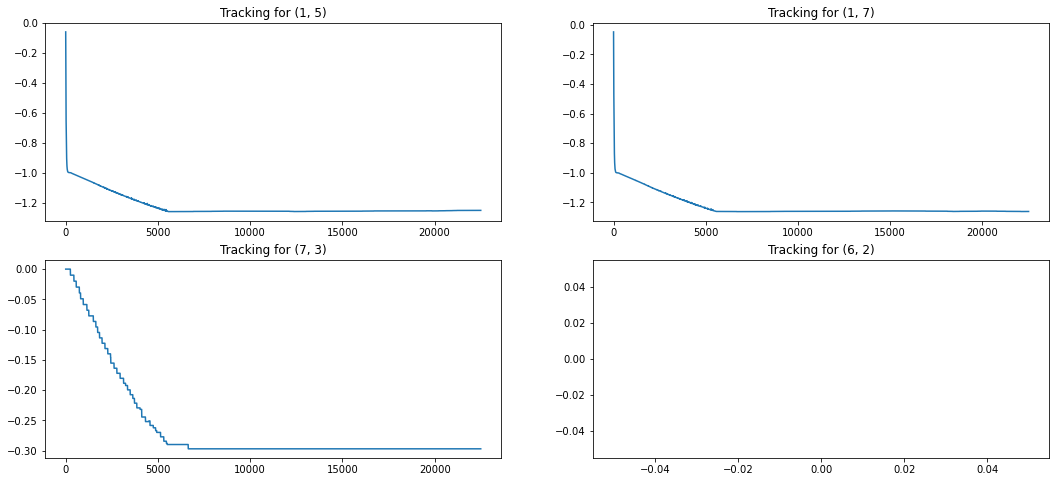

In [21]:

fig = plt.figure(0, figsize=(18, 8))
initial_subplot_value = 221

for idx, q_value in enumerate(sample_q_values):
    q_value_track = States_track[q_value[0]][q_value[1]]
    x_axis = np.asarray(range(0, len(q_value_track)))
    ax = fig.add_subplot(initial_subplot_value)
    ax.title.set_text(f"Tracking for {q_value[1]}")
    plt.plot(x_axis, np.asarray(q_value_track))
    initial_subplot_value += 1
plt.show()

**We can see that values are converging in above graph**

 ### Epsilon - decay check

In [22]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0, EPISODES)
epsilon = []
for i in range(0, EPISODES):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*i))

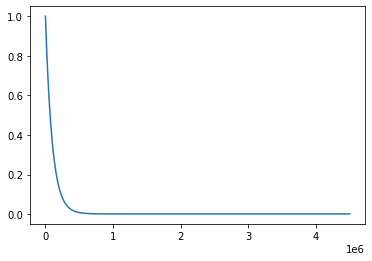

In [23]:
plt.plot(time, epsilon)
plt.show()